In [1]:
# This code uses line fit method to extrapolate dashed lines
# Bug: Sometimes the slopes are calculated wrong since all (x,y) points are used without elimination

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from scipy.optimize import curve_fit


In [2]:
def NegLineFit(img, line):
    xCurveDataNeg = np.array([])
    yCurveDataNeg = np.array([])
    for LinesNeg in line:
        for x1,y1,x2,y2 in LinesNeg:
            if ((y2-y1)/(x2-x1)) < 0:
                #plt.plot([x1, x2], [y1, y2],'*k')
                xCurveDataNeg = np.concatenate((xCurveDataNeg,np.array([x1, x2])))
                yCurveDataNeg = np.concatenate((yCurveDataNeg,np.array([y1, y2])))
    #plt.plot(xCurveDataNeg,yCurveDataNeg,'*k')

    def CurveFitFunc(x, a, b):
        return a * x + b
    def CurveFitFuncInv(y, a, b):
        return (y-b) / a

    popt, pcov = curve_fit(CurveFitFunc, xCurveDataNeg, yCurveDataNeg)
    #plt.plot(xCurveDataNeg, CurveFitFunc(xCurveDataNeg, *popt), 'r-',)

    yMax = img.shape[0]
    xStartNeg = CurveFitFuncInv(yMax, *popt)
    xEndNeg = CurveFitFuncInv(320, *popt)
    yCurveNeg = CurveFitFunc(np.array([xStartNeg, xEndNeg]), *popt) 
    LineNeg = [xStartNeg,max(yCurveNeg),xEndNeg,min(yCurveNeg)]
    LineNeg = [int(i) for i in LineNeg]
    return LineNeg

def PosLineFit(img, line):
    xCurveDataPos = np.array([])
    yCurveDataPos = np.array([])
    for LinesPos in line:
        for x1,y1,x2,y2 in LinesPos:
            if ((y2-y1)/(x2-x1)) > 0:
                #plt.plot([x1, x2], [y1, y2],'*k')
                xCurveDataPos = np.concatenate((xCurveDataPos,np.array([x1, x2])))
                yCurveDataPos = np.concatenate((yCurveDataPos,np.array([y1, y2])))
    #plt.plot(xCurveDataPos,yCurveDataPos,'*k')

    def CurveFitFunc(x, a, b):
        return a * x + b
    def CurveFitFuncInv(y, a, b):
        return (y-b) / a

    popt, pcov = curve_fit(CurveFitFunc, xCurveDataPos, yCurveDataPos)
    #plt.plot(xCurveDataPos, CurveFitFunc(xCurveDataPos, *popt), 'r-',)

    yMax = img.shape[0]
    xStartPos = CurveFitFuncInv(yMax, *popt)
    xEndPos = CurveFitFuncInv(320, *popt)
    yCurvePos = CurveFitFunc(np.array([xStartPos, xEndPos]), *popt) 
    LinePos = [xStartPos,max(yCurvePos),xEndPos,min(yCurvePos)]
    LinePos = [int(i) for i in LinePos]
    return LinePos

In [3]:
def draw_lines(img, Hlines, clr, thick):
    lineImg = np.copy(img)*0
    LinesFit = np.array([[NegLineFit(lineImg, Hlines)],[PosLineFit(lineImg, Hlines)]])
    for line in LinesFit:
        for x1,y1,x2,y2 in line:
            cv2.line(lineImg,(x1,y1),(x2,y2),clr,thick)
    #plt.imshow(lineImg)
    #combox = cv2.addWeighted(color_edges, 0.8, lineImg, 1, 0) 
    #plt.imshow(combox)
    return lineImg

In [4]:
def UpdatePicture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    plt.imshow(gray, cmap='gray')
    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

    # Define parameters for Canny and run it
    # NOTE: if you try running this code you might want to change these!
    low_threshold = 50
    high_threshold = 150
    masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(masked_edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(490, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(masked_edges, mask)

    # Display the image
    #plt.imshow(masked_edges, cmap='Greys_r')

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = 1*np.pi/180
    threshold = 15
    min_line_length = 20
    max_line_gap = 25
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
                                
    linesx = draw_lines(image, lines, [255, 0, 0], 10)
    #plt.imshow(linesx)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

    # Draw the lines on the edge image
    combox = cv2.addWeighted(color_edges, 0.8, linesx, 1, 0) 
    #plt.imshow(combox)

    UpdatedPicture = cv2.addWeighted(image, 1, linesx, 1, 0) 
    return UpdatedPicture

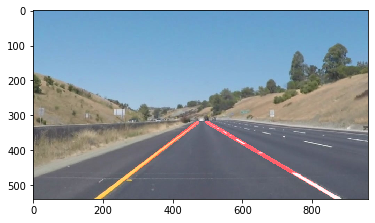

In [5]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
#image = mpimg.imread('asd/frame159.jpg')
ResultImage = UpdatePicture(image) 
plt.imshow(ResultImage)
#plt.savefig('test_images_results/ResultImage.jpg')

In [10]:
imagex = cv2.imread('test_images/solidWhiteCurve.jpg')
imagex = mpimg.imread('asd/frame0.jpg')
ResultImage = UpdatePicture(imagex) 
cv2.imshow('image',ResultImage)
cv2.waitKey(0)
#cv2.imwrite('test_images_results/Test_gray.jpg', ResultImage)

In [10]:
#for file in os.listdir('test_images/'): image = mpimg.imread(directory+file)
#plt.imshow(image)

In [ ]:
#pip install opencv-python
#pip install moviepy

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

t:  99%|█████████▉| 124/125 [00:03<00:00, 33.31it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 4.74 s


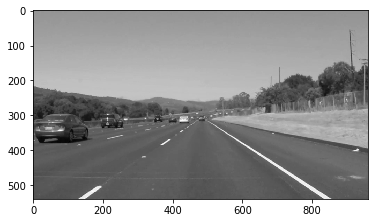

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(UpdatePicture) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

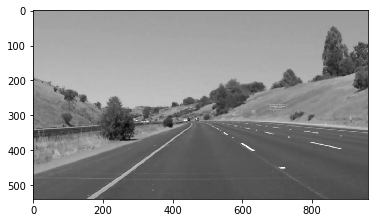

In [6]:
cap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
cap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
#cap = cv2.VideoCapture('test_videos/challenge.mp4')
vid_cod = cv2.VideoWriter_fourcc(*'XVID')
#output = cv2.VideoWriter("video.mp4", vid_cod, 20.0, (640,480))
count = 0
while(cap.isOpened()):
    ret, frame = cap.read()

    if ret:
        frame = UpdatePicture(frame)
        #name = "asd/frame%d.jpg"%count
        name = "aaa/frame%d.jpg"%count
        #cv2.waitKey(5)
        #cv2.imwrite(name, frame)
        cv2.imshow('frame',frame)
        count +=1
        #output.write(frame)
        cv2.waitKey(5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
#output.release()
cv2.destroyAllWindows()